In [1]:
from data_utils import cut_sp500, cut_oil, _read_sp500, _read_oil, get_raw_dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import random

In [2]:
assets_df = get_raw_dataset("trainTimeSeries/trainTimeSeries/TrainCandles")

100%|██████████| 96/96 [00:00<00:00, 2746.33it/s]


In [3]:
assets_df.shape

(13127, 96)

In [4]:
sp500 = _read_sp500("datos_series_temporales/IVE_tickbidask.txt")

In [5]:
oil = _read_oil("datos_series_temporales/OIH_adjusted.txt")

In [6]:
oil.columns

Index(['date_time', 'open', 'high', 'low', 'close', 'volume'], dtype='object')

In [7]:
def _save_pickle(obj, file):
    with open(file, "wb") as f:
        pickle.dump(obj, f)

In [8]:
def _load_pickle(file):
    with open(file, "rb") as f:
        pickle.load(f)

In [9]:
def _fix_df(df, prefix, period="H"):
    df.columns = ["date"] + [f"{prefix}_{col}" for col in df.columns if "date" not in col]
    df = df.resample(period, on="date").aggregate("mean")
    df.fillna(method="ffill", inplace=True)
    return df

In [10]:
def _get_below_cut(df, reference_df, prefix, last_date="2020-12-24 21:00:00"):
    first_date = reference_df.index[0]
    after_date = df["date_time"] >= first_date
    before_date = df["date_time"] <= pd.to_datetime(last_date)
    between = after_date & before_date
    df_cutted = df.loc[between]
    df_cutted = _fix_df(df_cutted, prefix)
    return df_cutted

In [11]:
oil_cutted = _get_below_cut(oil, assets_df, "oil")

In [12]:
sp500_cutted = _get_below_cut(sp500, assets_df, "sp500")

In [13]:
oil_cutted.shape

(17674, 5)

In [14]:
sp500_cutted.shape

(17673, 4)

In [15]:
scores = [0.5, 0.2, 0.3, 0.5, 0.1] + [0.0]*10
print(sum([s/sum(scores) for s in scores]))

1.0


In [16]:
oil_cutted.columns

Index(['oil_open', 'oil_high', 'oil_low', 'oil_close', 'oil_volume'], dtype='object')

In [17]:
oil_cutted.isna().sum()

oil_open      0
oil_high      0
oil_low       0
oil_close     0
oil_volume    0
dtype: int64

In [18]:
sp500_cutted.isna().sum()

sp500_price     0
sp500_bid       0
sp500_ask       0
sp500_volume    0
dtype: int64

In [19]:
def _save_scaler_variable(df, col, name):
    arr = df[col].values.reshape(-1, 1)
    scaler = StandardScaler()
    scaler.fit_transform(arr)
    _save_pickle(scaler, f"scaler_{name}.pkl")
    return scaler

In [20]:
scaler_vol_oil = _save_scaler_variable(oil_cutted, "oil_volume", "vol_oil")

In [21]:
scaler_vol_sp = _save_scaler_variable(sp500_cutted, "sp500_volume", "vol_sp500")

In [22]:
logret_cols = ["open", "high", "low", "close", "price", "bid", "ask"]

In [23]:
def preprocess_data(df, reference_df, name, scaler):
    df = _fill_dates(df, reference_df)
    if f"{name}_bid" in df.columns:
        df[f"{name}_spread"] = (df[f"{name}_ask"] - df[f"{name}_bid"]) / df[f"{name}_price"]
    cols_logret = [col for col in df.columns if any([c in col for c in logret_cols])]
    print(cols_logret)
    for col in cols_logret:
        df.loc[:, col] = np.log(df[col]) - np.log(df[col].shift(1))
    #scaler = _load_pickle(f"scaler_vol_{name}.pkl")
    df[f"{name}_volume"] = scaler.transform(df[f"{name}_volume"].values.reshape(-1, 1))
    return df

In [151]:
def _fill_dates(df, ref_df):
    dates_ = pd.DataFrame({"date": ref_df.index}).set_index("date")
    df = pd.merge(df, dates_, left_index=True, right_index=True, how="outer")
    df.fillna(method="ffill", inplace=True)
    return df
    

In [152]:
oildf = cut_oil(oil, assets_df)

In [153]:
sp500df = cut_sp500(sp500, assets_df)

In [154]:
oil_processed = preprocess_data(oildf, assets_df, "oil", scaler_vol_oil)

['oil_open', 'oil_high', 'oil_low', 'oil_close']


In [155]:
sp500_processed = preprocess_data(sp500df, assets_df, "sp500", scaler_vol_sp)

['sp500_price', 'sp500_bid', 'sp500_ask']


/home/alejandro.vaca/miniconda/envs/series_temporales/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [161]:
sp500_processed.isna().sum()

sp500_price       9
sp500_bid        69
sp500_ask       157
sp500_volume      8
sp500_spread      8
dtype: int64

In [162]:
oil_processed.isna().sum()

oil_open      8
oil_high      8
oil_low       8
oil_close     8
oil_volume    7
dtype: int64

In [166]:
oil_processed.head(20)

,oil_open,oil_high,oil_low,oil_close,oil_volume
date,,,,,
2018-12-19 01:00:00,NaN,NaN,NaN,NaN,NaN
2018-12-19 02:00:00,NaN,NaN,NaN,NaN,NaN
2018-12-19 03:00:00,NaN,NaN,NaN,NaN,NaN
2018-12-19 04:00:00,NaN,NaN,NaN,NaN,NaN
2018-12-19 05:00:00,NaN,NaN,NaN,NaN,NaN
2018-12-19 06:00:00,NaN,NaN,NaN,NaN,NaN
2018-12-19 07:00:00,NaN,NaN,NaN,NaN,NaN
2018-12-19 08:00:00,NaN,NaN,NaN,NaN,-0.170267
2018-12-19 09:00:00,-0.000825,0.000194,-0.001720,-0.000788,0.263023


In [167]:
def _postprocess(df):
    df.fillna(0, inplace=True)
    return df

In [168]:
sp500_processed, oil_processed = _postprocess(sp500_processed), _postprocess(oil_processed)

In [244]:
total_df = pd.merge(sp500_processed, oil_processed, on="date")

In [245]:
total_df.shape

(13127, 10)

In [246]:
total_df.head()

,sp500_price,sp500_bid,sp500_ask,sp500_volume,sp500_spread,oil_open,oil_high,oil_low,oil_close,oil_volume
date,,,,,,,,,,
2018-12-19 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-19 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-19 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-19 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-12-19 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [247]:
total_df.index.minute

Int64Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            ...
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           dtype='int64', name='date', length=13127)

In [248]:
def _get_time_attributes(df):
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    sin_day, cos_day = _get_sine_cosine(df.day, 30)
    sin_hour, cos_hour = _get_sine_cosine(df.hour, 24)
    df.drop(["day", "hour"], axis=1, inplace=True)
    df["sin_day"] = sin_day
    df["cos_day"] = cos_day
    df["sin_hour"] = sin_hour
    df["cos_hour"] = cos_hour
    return df

In [249]:
def _get_sine_cosine(dates, period):
    sin = np.sin(
        2 * np.pi * dates / period
    )
    cos = np.cos(
        2 * np.pi * dates / period
    )
    return sin, cos

In [280]:
def build_obs_df(df, assetsdf):
    #dates = pd.DatetimeIndex(df.index).asi8 #df.index.astype(np.int64) // 10**9
    df = _get_time_attributes(df)
    df = _which_assets_available(df, assetsdf)
    return df

In [279]:
def _which_assets_available(df, assets_df):
    assets_df.fillna(method="ffill", inplace=True)
    values = [assets_df.iloc[i, :].notna().values.astype("int") for i in trange(assets_df.shape[0])]
    columns = [f"{col.replace('_close', '')}_available" for col in assets_df.columns]
    df_available = pd.DataFrame(values, columns = columns, index=assets_df.index)
    df = pd.merge(df, df_available, left_index=True, right_index=True, how="outer")
    return df
    

In [282]:
#values = [assets_df.iloc[i, :].notna().values.astype("int") for i in range(assets_df.shape[0])]

In [283]:
#columns = assets_df.columns

In [284]:
#len(values), len(columns)

In [281]:
#pd.DataFrame(values, columns = columns, index=assets_df.index)

In [285]:
obs_df = build_obs_df(total_df, assets_df)

100%|██████████| 13127/13127 [00:05<00:00, 2494.33it/s]


In [286]:
obs_df.head()

,sp500_price,sp500_bid,sp500_ask,sp500_volume,sp500_spread,oil_open,oil_high,oil_low,oil_close,oil_volume,...,AZG_available,OJG_available,WWT_available,BOT_available,TXR_available,RAT_available,DIG_available,SRI_available,PHI_available,RWJ_available
date,,,,,,,,,,,,,,,,,,,,,
2018-12-19 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,1,0,1,0,0
2018-12-19 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,1,0,1,0,0
2018-12-19 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,1,0,1,0,0
2018-12-19 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,1,0,1,0,0
2018-12-19 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,1,0,1,0,0


In [287]:
import matplotlib.pyplot as plt

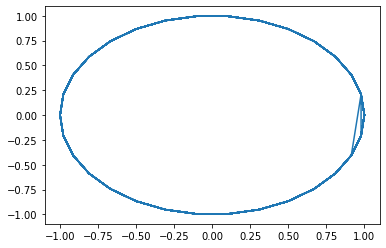

In [288]:
plt.plot(obs_df.cos_day, obs_df.sin_day)

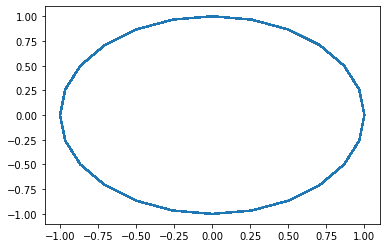

In [289]:
plt.plot(obs_df.cos_hour, obs_df.sin_hour)

In [337]:
obs_df.to_csv("observations_df.csv", header=True, index=True)

In [254]:
assets_df.head()

,ZVQ_close,NCT_close,YAX_close,OOS_close,GFJ_close,FIR_close,USX_close,FSK_close,TMF_close,TDD_close,...,AZG_close,OJG_close,WWT_close,BOT_close,TXR_close,RAT_close,DIG_close,SRI_close,PHI_close,RWJ_close
date,,,,,,,,,,,,,,,,,,,,,
2018-12-19 01:00:00,519.23,NaN,NaN,NaN,NaN,NaN,NaN,154.69,NaN,116.07,...,129.87,NaN,129.98,NaN,NaN,140.36,NaN,92.19,NaN,NaN
2018-12-19 02:00:00,519.63,NaN,NaN,NaN,NaN,NaN,NaN,155.01,NaN,116.25,...,129.95,NaN,130.02,NaN,NaN,140.55,NaN,92.11,NaN,NaN
2018-12-19 03:00:00,519.95,NaN,NaN,NaN,NaN,NaN,NaN,155.08,NaN,116.45,...,130.07,NaN,130.10,NaN,NaN,140.51,NaN,92.12,NaN,NaN
2018-12-19 04:00:00,520.09,NaN,NaN,NaN,NaN,NaN,NaN,155.16,NaN,116.65,...,130.26,NaN,130.50,NaN,NaN,140.57,NaN,92.18,NaN,NaN
2018-12-19 05:00:00,520.06,NaN,NaN,NaN,NaN,NaN,NaN,155.23,NaN,116.30,...,130.07,NaN,130.28,NaN,NaN,140.50,NaN,92.07,NaN,NaN


In [255]:
assets_df.fillna(method="ffill", inplace=True)

In [256]:
assets_df.head()

,ZVQ_close,NCT_close,YAX_close,OOS_close,GFJ_close,FIR_close,USX_close,FSK_close,TMF_close,TDD_close,...,AZG_close,OJG_close,WWT_close,BOT_close,TXR_close,RAT_close,DIG_close,SRI_close,PHI_close,RWJ_close
date,,,,,,,,,,,,,,,,,,,,,
2018-12-19 01:00:00,519.23,NaN,NaN,NaN,NaN,NaN,NaN,154.69,NaN,116.07,...,129.87,NaN,129.98,NaN,NaN,140.36,NaN,92.19,NaN,NaN
2018-12-19 02:00:00,519.63,NaN,NaN,NaN,NaN,NaN,NaN,155.01,NaN,116.25,...,129.95,NaN,130.02,NaN,NaN,140.55,NaN,92.11,NaN,NaN
2018-12-19 03:00:00,519.95,NaN,NaN,NaN,NaN,NaN,NaN,155.08,NaN,116.45,...,130.07,NaN,130.10,NaN,NaN,140.51,NaN,92.12,NaN,NaN
2018-12-19 04:00:00,520.09,NaN,NaN,NaN,NaN,NaN,NaN,155.16,NaN,116.65,...,130.26,NaN,130.50,NaN,NaN,140.57,NaN,92.18,NaN,NaN
2018-12-19 05:00:00,520.06,NaN,NaN,NaN,NaN,NaN,NaN,155.23,NaN,116.30,...,130.07,NaN,130.28,NaN,NaN,140.50,NaN,92.07,NaN,NaN


In [291]:
import datetime

In [294]:
ultima_fecha = assets_df.index[-1] - datetime.timedelta(days=28*6)

In [295]:
ultima_fecha

Timestamp('2020-01-01 23:00:00', freq='H')

In [296]:
assets_df.index[-1]

Timestamp('2020-06-17 23:00:00', freq='H')

In [300]:
assets_df.columns

Index(['ZVQ_close', 'NCT_close', 'YAX_close', 'OOS_close', 'GFJ_close',
       'FIR_close', 'USX_close', 'FSK_close', 'TMF_close', 'TDD_close',
       'HEO_close', 'ULT_close', 'CSB_close', 'CIS_close', 'UYZ_close',
       'TRO_close', 'YEC_close', 'ERO_close', 'ZAB_close', 'HZY_close',
       'MUF_close', 'ZTY_close', 'PUL_close', 'JHI_close', 'LWE_close',
       'SEH_close', 'AWW_close', 'GRI_close', 'REU_close', 'ACY_close',
       'MMY_close', 'VRT_close', 'ZXW_close', 'LUG_close', 'VVC_close',
       'CBY_close', 'WFJ_close', 'PPT_close', 'PEW_close', 'MCA_close',
       'IDT_close', 'FFV_close', 'LWK_close', 'ZCD_close', 'ULI_close',
       'AUX_close', 'DZF_close', 'NWO_close', 'BAX_close', 'HCC_close',
       'JNE_close', 'JTL_close', 'UPP_close', 'WXN_close', 'XRX_close',
       'UEI_close', 'LHB_close', 'NYD_close', 'BGN_close', 'SHC_close',
       'THA_close', 'TKT_close', 'GRU_close', 'BFS_close', 'SKN_close',
       'NVL_close', 'YFC_close', 'GGR_close', 'TER_close', 'NYP_

In [306]:
fechas_previas = assets_df.loc[assets_df.index <= ultima_fecha].index


In [307]:
fechas_previas

DatetimeIndex(['2018-12-19 01:00:00', '2018-12-19 02:00:00',
               '2018-12-19 03:00:00', '2018-12-19 04:00:00',
               '2018-12-19 05:00:00', '2018-12-19 06:00:00',
               '2018-12-19 07:00:00', '2018-12-19 08:00:00',
               '2018-12-19 09:00:00', '2018-12-19 10:00:00',
               ...
               '2020-01-01 14:00:00', '2020-01-01 15:00:00',
               '2020-01-01 16:00:00', '2020-01-01 17:00:00',
               '2020-01-01 18:00:00', '2020-01-01 19:00:00',
               '2020-01-01 20:00:00', '2020-01-01 21:00:00',
               '2020-01-01 22:00:00', '2020-01-01 23:00:00'],
              dtype='datetime64[ns]', name='date', length=9095, freq='H')

In [309]:
start_date = random.choice(fechas_previas)

In [310]:
start_date

Timestamp('2019-09-13 09:00:00', freq='H')

In [311]:
game_df = obs_df.loc[obs_df.index >= start_date]

In [312]:
game_df

,sp500_price,sp500_bid,sp500_ask,sp500_volume,sp500_spread,oil_open,oil_high,oil_low,oil_close,oil_volume,...,AZG_available,OJG_available,WWT_available,BOT_available,TXR_available,RAT_available,DIG_available,SRI_available,PHI_available,RWJ_available
date,,,,,,,,,,,,,,,,,,,,,
2019-09-13 09:00:00,0.002731,0.006494,-0.015030,-0.040882,0.000253,0.011911,0.013715,0.010036,0.011781,0.821679,...,1,1,1,1,1,1,1,1,1,1
2019-09-13 10:00:00,-0.000797,-0.000769,-0.000853,-0.034780,0.000170,-0.010588,-0.011240,-0.009459,-0.010354,0.195454,...,1,1,1,1,1,1,1,1,1,1
2019-09-13 11:00:00,0.000916,0.000940,0.000908,-0.031434,0.000137,0.000622,0.000086,0.000876,0.000554,0.026378,...,1,1,1,1,1,1,1,1,1,1
2019-09-13 12:00:00,-0.000815,-0.000806,-0.000815,-0.043966,0.000129,0.002464,0.002236,0.002638,0.002495,-0.025115,...,1,1,1,1,1,1,1,1,1,1
2019-09-13 13:00:00,-0.000421,-0.000438,-0.000429,-0.037493,0.000137,0.002889,0.002859,0.002802,0.002772,0.003141,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-17 19:00:00,0.000000,0.000000,0.000000,-0.054763,0.031562,0.000000,0.000000,0.000000,0.000000,-0.184344,...,1,1,1,1,1,1,1,1,1,1
2020-06-17 20:00:00,0.000000,-0.005920,0.001518,-0.054763,0.038908,0.000000,0.000000,0.000000,0.000000,-0.184344,...,1,1,1,1,1,1,1,1,1,1
2020-06-17 21:00:00,0.000000,0.000000,0.000000,-0.054763,0.038908,0.000000,0.000000,0.000000,0.000000,-0.184344,...,1,1,1,1,1,1,1,1,1,1


In [317]:
len(game_df.iloc[2, :].values)

110

In [318]:
obs_df.columns

Index(['sp500_price', 'sp500_bid', 'sp500_ask', 'sp500_volume', 'sp500_spread',
       'oil_open', 'oil_high', 'oil_low', 'oil_close', 'oil_volume',
       ...
       'AZG_available', 'OJG_available', 'WWT_available', 'BOT_available',
       'TXR_available', 'RAT_available', 'DIG_available', 'SRI_available',
       'PHI_available', 'RWJ_available'],
      dtype='object', length=110)

In [319]:
actions = [random.uniform(0,1) for _ in range(assets_df.shape[1])]

In [322]:
actions = np.array(actions) / sum(actions)

In [325]:
np.dot(actions, assets_df.fillna(0).iloc[0, :].values)

35.20511226140741

In [326]:
game_df.head()

,sp500_price,sp500_bid,sp500_ask,sp500_volume,sp500_spread,oil_open,oil_high,oil_low,oil_close,oil_volume,...,AZG_available,OJG_available,WWT_available,BOT_available,TXR_available,RAT_available,DIG_available,SRI_available,PHI_available,RWJ_available
date,,,,,,,,,,,,,,,,,,,,,
2019-09-13 09:00:00,0.002731,0.006494,-0.015030,-0.040882,0.000253,0.011911,0.013715,0.010036,0.011781,0.821679,...,1,1,1,1,1,1,1,1,1,1
2019-09-13 10:00:00,-0.000797,-0.000769,-0.000853,-0.034780,0.000170,-0.010588,-0.011240,-0.009459,-0.010354,0.195454,...,1,1,1,1,1,1,1,1,1,1
2019-09-13 11:00:00,0.000916,0.000940,0.000908,-0.031434,0.000137,0.000622,0.000086,0.000876,0.000554,0.026378,...,1,1,1,1,1,1,1,1,1,1
2019-09-13 12:00:00,-0.000815,-0.000806,-0.000815,-0.043966,0.000129,0.002464,0.002236,0.002638,0.002495,-0.025115,...,1,1,1,1,1,1,1,1,1,1
2019-09-13 13:00:00,-0.000421,-0.000438,-0.000429,-0.037493,0.000137,0.002889,0.002859,0.002802,0.002772,0.003141,...,1,1,1,1,1,1,1,1,1,1


In [327]:
game_df.iloc[0]

sp500_price      0.002731
sp500_bid        0.006494
sp500_ask       -0.015030
sp500_volume    -0.040882
sp500_spread     0.000253
                   ...   
RAT_available    1.000000
DIG_available    1.000000
SRI_available    1.000000
PHI_available    1.000000
RWJ_available    1.000000
Name: 2019-09-13 09:00:00, Length: 110, dtype: float64

In [330]:
assets_df.head()

,ZVQ_close,NCT_close,YAX_close,OOS_close,GFJ_close,FIR_close,USX_close,FSK_close,TMF_close,TDD_close,...,AZG_close,OJG_close,WWT_close,BOT_close,TXR_close,RAT_close,DIG_close,SRI_close,PHI_close,RWJ_close
date,,,,,,,,,,,,,,,,,,,,,
2018-12-19 01:00:00,519.23,0.0,0.0,0.0,0.0,0.0,0.0,154.69,0.0,116.07,...,129.87,0.0,129.98,0.0,0.0,140.36,0.0,92.19,0.0,0.0
2018-12-19 02:00:00,519.63,0.0,0.0,0.0,0.0,0.0,0.0,155.01,0.0,116.25,...,129.95,0.0,130.02,0.0,0.0,140.55,0.0,92.11,0.0,0.0
2018-12-19 03:00:00,519.95,0.0,0.0,0.0,0.0,0.0,0.0,155.08,0.0,116.45,...,130.07,0.0,130.10,0.0,0.0,140.51,0.0,92.12,0.0,0.0
2018-12-19 04:00:00,520.09,0.0,0.0,0.0,0.0,0.0,0.0,155.16,0.0,116.65,...,130.26,0.0,130.50,0.0,0.0,140.57,0.0,92.18,0.0,0.0
2018-12-19 05:00:00,520.06,0.0,0.0,0.0,0.0,0.0,0.0,155.23,0.0,116.30,...,130.07,0.0,130.28,0.0,0.0,140.50,0.0,92.07,0.0,0.0


In [329]:
assets_df.fillna(0, inplace=True)

In [334]:
assets_df.to_csv("assets_df.csv", header=True, index=True)

In [335]:
adf = pd.read_csv("assets_df.csv")

In [336]:
adf.head()

,date,ZVQ_close,NCT_close,YAX_close,OOS_close,GFJ_close,FIR_close,USX_close,FSK_close,TMF_close,...,AZG_close,OJG_close,WWT_close,BOT_close,TXR_close,RAT_close,DIG_close,SRI_close,PHI_close,RWJ_close
0,2018-12-19 01:00:00,519.23,0.0,0.0,0.0,0.0,0.0,0.0,154.69,0.0,...,129.87,0.0,129.98,0.0,0.0,140.36,0.0,92.19,0.0,0.0
1,2018-12-19 02:00:00,519.63,0.0,0.0,0.0,0.0,0.0,0.0,155.01,0.0,...,129.95,0.0,130.02,0.0,0.0,140.55,0.0,92.11,0.0,0.0
2,2018-12-19 03:00:00,519.95,0.0,0.0,0.0,0.0,0.0,0.0,155.08,0.0,...,130.07,0.0,130.10,0.0,0.0,140.51,0.0,92.12,0.0,0.0
3,2018-12-19 04:00:00,520.09,0.0,0.0,0.0,0.0,0.0,0.0,155.16,0.0,...,130.26,0.0,130.50,0.0,0.0,140.57,0.0,92.18,0.0,0.0
4,2018-12-19 05:00:00,520.06,0.0,0.0,0.0,0.0,0.0,0.0,155.23,0.0,...,130.07,0.0,130.28,0.0,0.0,140.50,0.0,92.07,0.0,0.0


In [1]:
scaler_vol_oil

NameError: name 'scaler_vol_oil' is not defined